# Vegetation detections using mixed channels with basic unet network

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import os
import logging
import sys
sys.path.append("../common/")

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
from data_utils import TRAIN_IMAGE_IDS, LABELS
from image_utils import get_image_data, TRAIN_DATA, TRAIN_LABEL_TILES, get_image_tile_data, normalize, make_ratios_vegetation
from visu_utils import display_img_1b, display_labels

In [4]:
import cv2

### Input data

Images of shape (512, 512, 17) 

In [5]:
for i, l in enumerate(LABELS):
    print i, l

0 None
1 Buildings
2 Misc. Manmade structures
3 Road
4 Track
5 Trees
6 Crops
7 Waterway
8 Standing water
9 Vehicle Large
10 Vehicle Small


In [6]:
from glob import glob
all_train_files = glob(os.path.join(TRAIN_DATA, "*.tif"))
all_train_files = np.array([s[len(TRAIN_DATA)+1:-4] for s in all_train_files])
print "First train tile : ", all_train_files[0], len(all_train_files)

First train tile :  6010_1_2 25


In [7]:
# from image_utils import compute_mean_std_on_images

ll = int(len(all_train_files)*0.8)
train_files = all_train_files[:ll]
val_files = all_train_files[ll:]


# mean_fname = os.path.join(TRAIN_DATA, 'mean_image.npz')
# std_fname = os.path.join(TRAIN_DATA, 'std_image.npz')
# if not os.path.exists(mean_fname) or not os.path.exists(std_fname):
#     logging.getLogger().setLevel(logging.INFO)
#     mean_image, std_image = compute_mean_std_on_images(train_files)
#     logging.getLogger().setLevel(logging.ERROR)
#     np.savez(mean_fname, mean_image)
#     np.savez(std_fname, std_image)
# else:
#     mean_image = np.load(mean_fname)['arr_0']
#     std_image = np.load(std_fname)['arr_0']

# print mean_image.shape, std_image.shape
# print mean_image.min(), mean_image.max(), std_image.min(), std_image.max()
# print len(train_files), len(val_files)

logging.getLogger().setLevel(logging.ERROR)

In [9]:
from data_utils import get_image_ids
from training_utils import tile_iterator

def normalize_image(img_data, mean_image=None, std_image=None):
    out = img_data.astype(np.float32)    
    if mean_image is not None or std_image is not None:
        out -= mean_image 
        out /= std_image
    out = out.transpose([2,0,1])
    return out

def generate_images(image_ids_to_use, batch_size):
    while True:        
        X = np.zeros((batch_size, n_channels)+tile_size, dtype=np.float32)
        Y = np.zeros((batch_size, n_labels)+tile_size, dtype=np.float32)
        tiles = tile_iterator(image_ids_to_use, labels, 
                              presence_percentage=2, 
                              tile_size=tile_size, 
                              #mean_image=mean_image,
                              #std_image=std_image
                             )
        counter = 0
        for x, y in tiles:     

            if len(channels) < 17:
                x = x[:,:,channels]

            # generate all possible ratios
            x = make_ratios_vegetation(x)            
            
            x = normalize_image(x)
            y = normalize_image(y)     

            X[counter,:,:,:] = x
            Y[counter,:,:,:] = y 
            counter += 1
            if counter == batch_size:
                yield (X, Y)
                counter = 0

Training class groups : number of pixels x appearence frequency ~ probability that a pixel of the image is of a class

1. `Buildings` and `Misc. Manmade structures` and `Track` : [1, 2, 4]
2. `Standing water` and `Road` and `Waterway` : [8, 3, 7]
3. `Trees` and `Crops`: [5, 6]
4. `Vehicle Small` : [10]
5. `Vehicle Large` : [9]


In [12]:
tile_size = (256, 256)
channels = np.array(range(17))
# channels = np.array([0, 1, 2, 3, 4])
#n_channels = len(channels)

n_channels = 23

# labels = np.array(range(len(LABELS)))
labels = np.array([5, 6])
n_labels = len(labels)

(5L, 23L, 256L, 256L) (5L, 2L, 256L, 256L)
0.0 6.34931 0.0 1.0


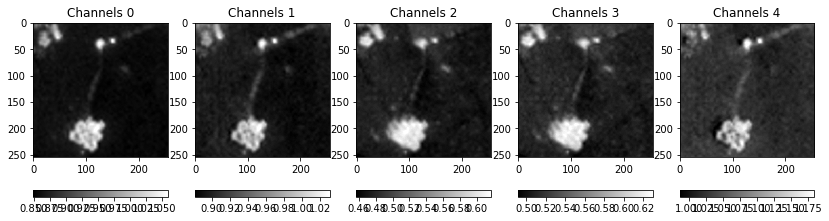

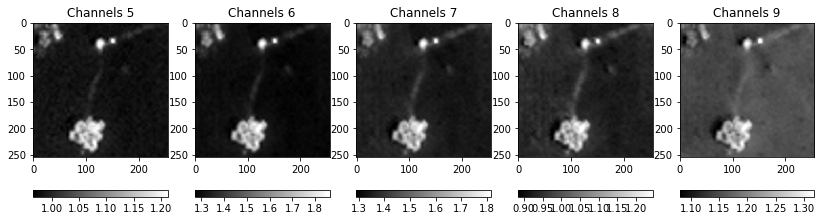

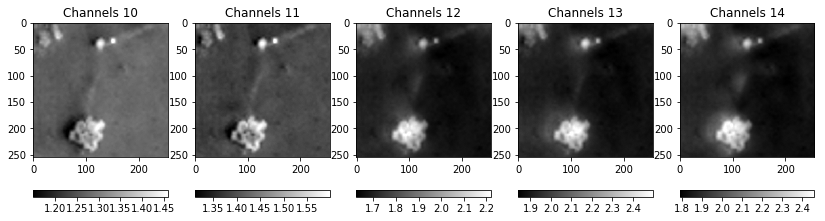

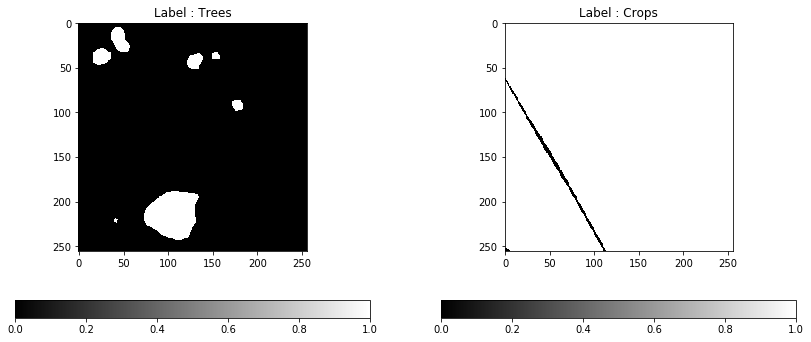

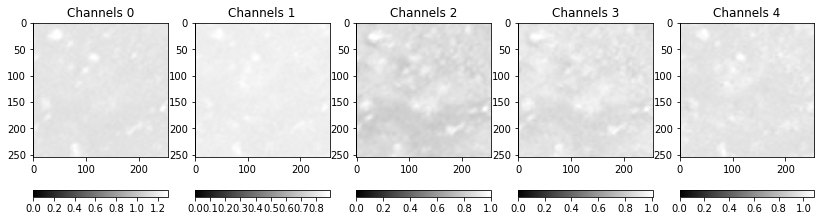

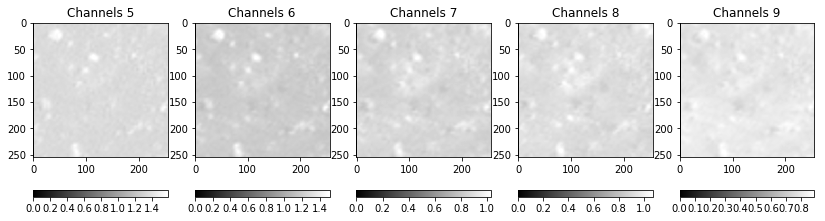

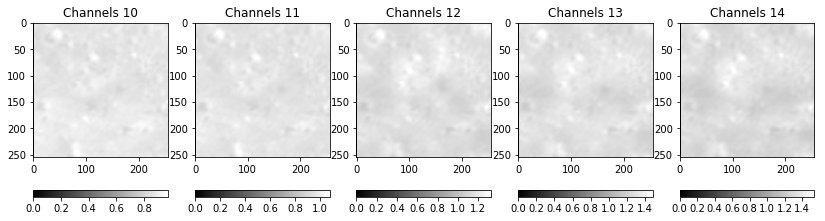

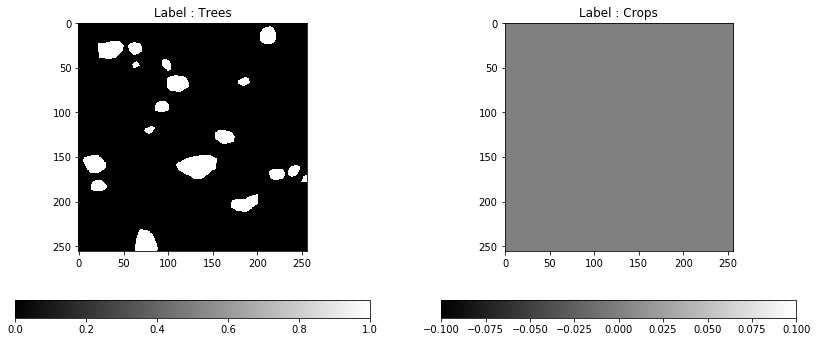

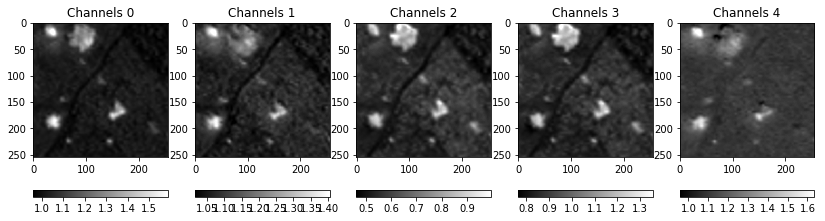

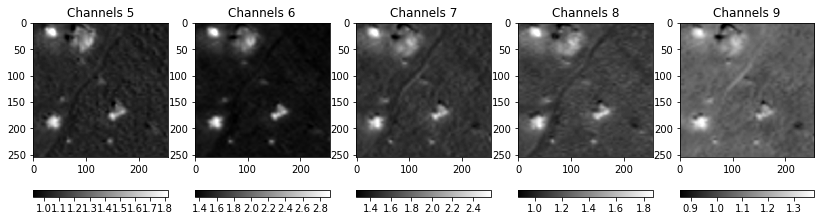

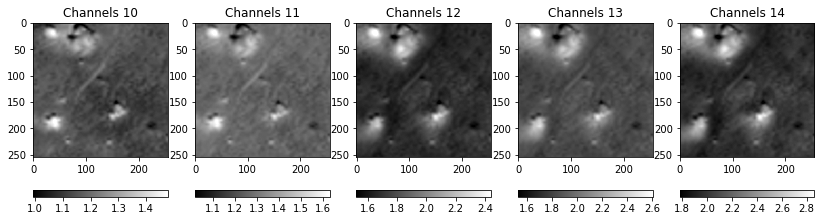

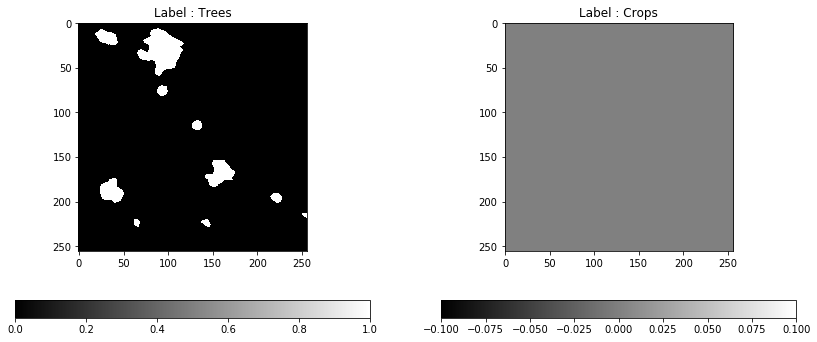

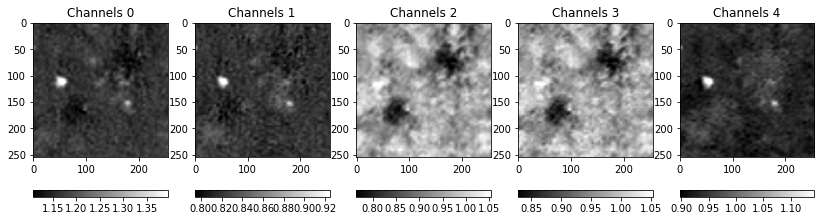

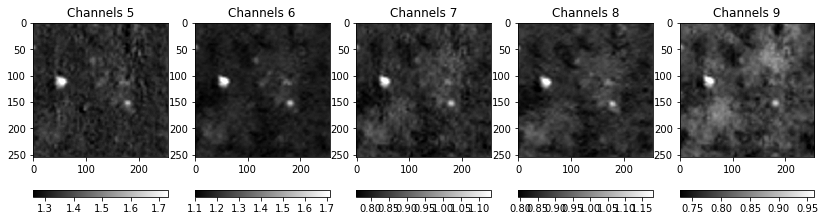

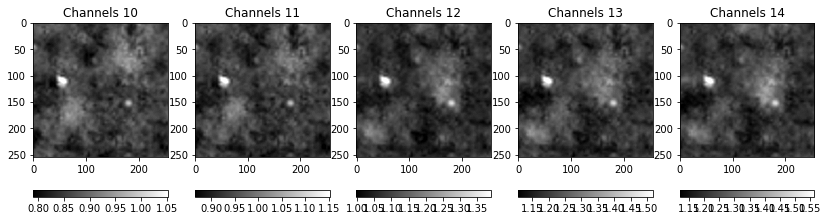

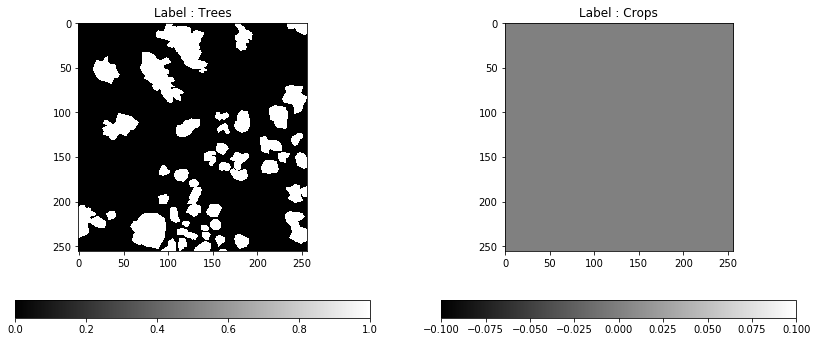

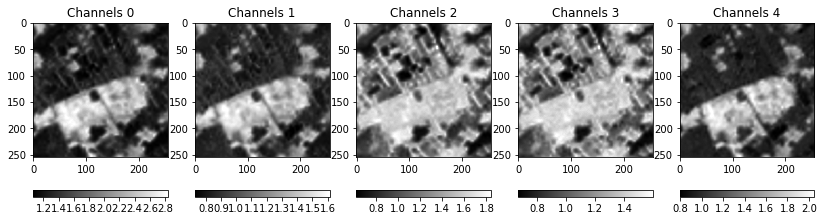

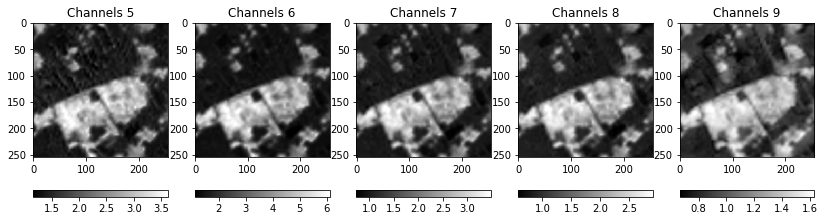

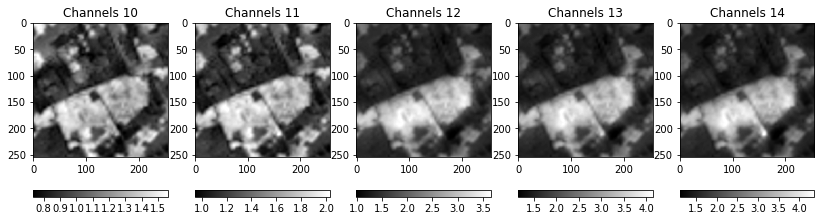

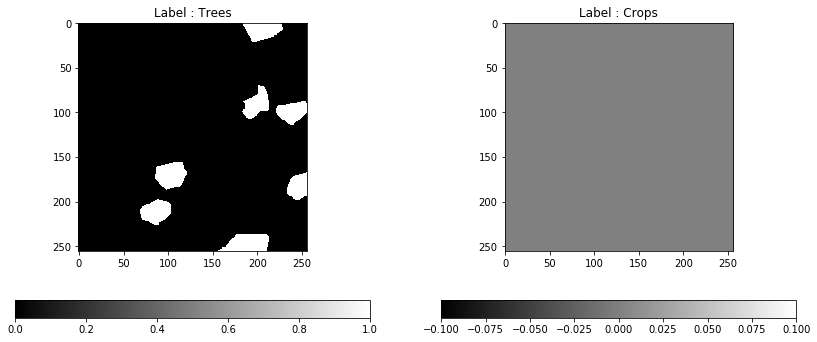

In [13]:
batch_size = 5
for X, Y in generate_images(train_files, batch_size):
    print X.shape, Y.shape
    print X.min(), X.max(), Y.min(), Y.max()
    
    _channels = min(15, n_channels)
    for i in range(batch_size):
        
        n, m = 3, int(_channels * 1.0 / 3.0 + 0.5)
        for j in range(_channels):
            if j % m == 0:
                plt.figure(figsize=(14, 4))                
            plt.subplot(1,m,j % m +1)
            display_img_1b(X[i,j,:,:])
            plt.title("Channels %i" % j)
                
        plt.figure(figsize=(14, 6))    
        if n_labels < 8:
            n, m = 1, n_labels
        else:
            n, m = 3, int(n_labels * 1.0 / 3.0 + 0.5), 
        for j in range(n_labels):
            plt.subplot(n, m,j+1)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label : %s" % LABELS[labels[j]])

    break

In [14]:
import os
from keras.optimizers import Adam, Nadam, SGD, Adadelta
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from metrics import jaccard_coef, jaccard_coef_int

from unet import unet_zero_prime

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release.  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 750 Ti (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 4007)


Keras user configuration is setup


In [21]:
deep=False 
n_filters_0=32

model = unet_zero_prime(n_labels, n_channels, *tile_size, deep=deep, n_filters_0=n_filters_0)

weights_filename = os.path.join("weights", "unet_two_%i_%i_%s_%i.h5.store" % (n_channels, n_labels, str(deep), n_filters_0))
# if os.path.exists(weights_filename):
#     print "Found weights file %s" % weights_filename
#     model.load_weights(weights_filename)

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 272, 256, 256) 0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 256, 256)  8736        input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 256, 256)  2112        convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (None, 32, 256, 256)  18464       convolution2d_2[0][0]            
___________________________________________________________________________________________

In [23]:
if not os.path.exists('weights'):
    os.mkdir('weights')
    
model_checkpoint = ModelCheckpoint(weights_filename, monitor='loss', save_best_only=True)
#earlyStop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0)

# LearningRateScheduler

In [24]:
# model.compile(optimizer=Nadam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Nadam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
# model.compile(optimizer=Adam(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

# sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])

model.compile(optimizer=Adadelta(lr=0.01), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'recall', 'precision'])

In [29]:
# foo = lambda x: max(x // 10, min(batch_size * 10, x))

batch_size = 4
samples_per_epoch = 64
nb_val_samples = 16


print batch_size, samples_per_epoch, nb_val_samples

history = model.fit_generator(
    generate_images(train_files, batch_size),
    samples_per_epoch=samples_per_epoch, 
    nb_epoch=10,
    validation_data=generate_images(val_files, batch_size),
    nb_val_samples=nb_val_samples,
    callbacks=[model_checkpoint],
    verbose=2
)

4 64 16
Epoch 1/10
51s - loss: 28.7167 - jaccard_coef: 0.0188 - jaccard_coef_int: 2.9736e-04 - recall: 8.9375e-04 - precision: 0.0324 - val_loss: 28.6344 - val_jaccard_coef: 0.0109 - val_jaccard_coef_int: 4.5725e-05 - val_recall: 1.7631e-04 - val_precision: 0.0031
Epoch 2/10
38s - loss: 28.6573 - jaccard_coef: 0.0205 - jaccard_coef_int: 1.4731e-04 - recall: 3.6247e-04 - precision: 0.0273 - val_loss: 28.5518 - val_jaccard_coef: 0.0106 - val_jaccard_coef_int: 1.6007e-05 - val_recall: 7.3115e-05 - val_precision: 0.0012
Epoch 3/10
37s - loss: 28.5526 - jaccard_coef: 0.0198 - jaccard_coef_int: 3.3903e-04 - recall: 0.0010 - precision: 0.1109 - val_loss: 28.4636 - val_jaccard_coef: 0.0102 - val_jaccard_coef_int: 1.4419e-05 - val_recall: 4.9858e-05 - val_precision: 0.0040
Epoch 4/10
39s - loss: 28.4433 - jaccard_coef: 0.0154 - jaccard_coef_int: 1.6753e-04 - recall: 3.0471e-04 - precision: 0.0511 - val_loss: 28.3641 - val_jaccard_coef: 0.0109 - val_jaccard_coef_int: 3.7469e-05 - val_recall: 1.4

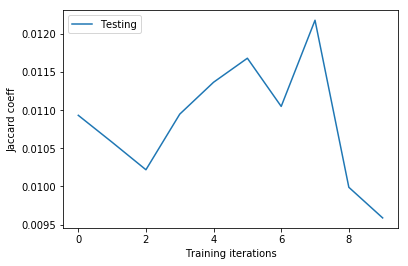

In [30]:
# plt.plot(history.history['val_jaccard_coef_int'])
# plt.ylabel('Jaccard coeff integer')
plt.plot(history.history['val_jaccard_coef'])
plt.ylabel('Jaccard coeff')
plt.xlabel('Training iterations')
plt.legend(['Testing'], loc='upper left')
plt.show()

In [37]:
def _plot(X, Y, Y_pred, i, c=1):
    plt.figure(figsize=(12,6))
    plt.subplot(131)
    display_img_1b(X[i,0,:,:])
    plt.subplot(132)
    display_img_1b(Y[i,c,:,:])
    plt.subplot(133)
    display_img_1b(Y_pred[i,c,:,:])

(5L, 3L, 256L, 256L) 0.0073951 0.690617


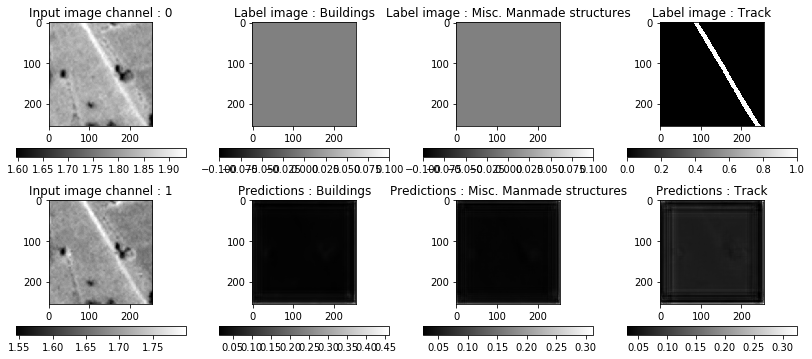

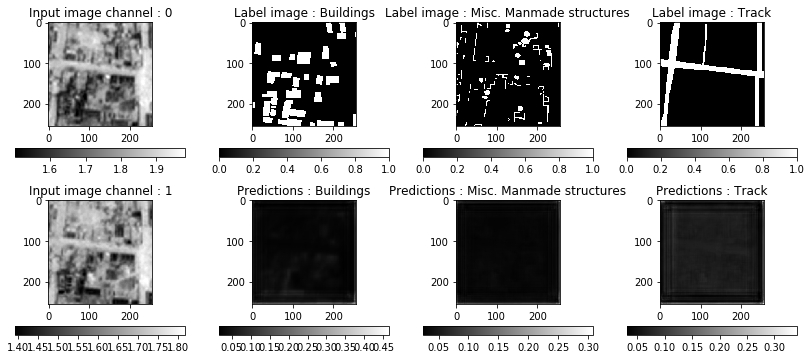

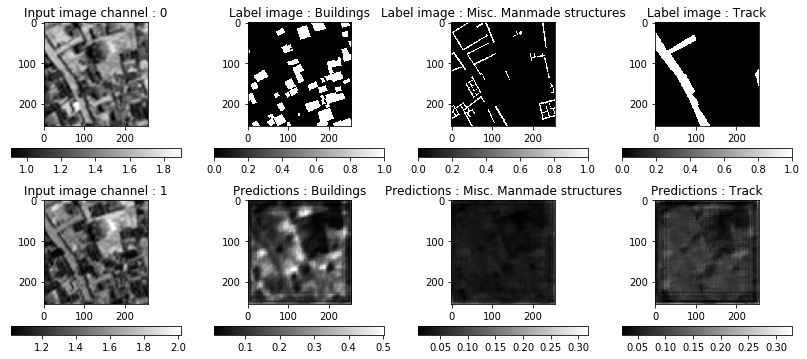

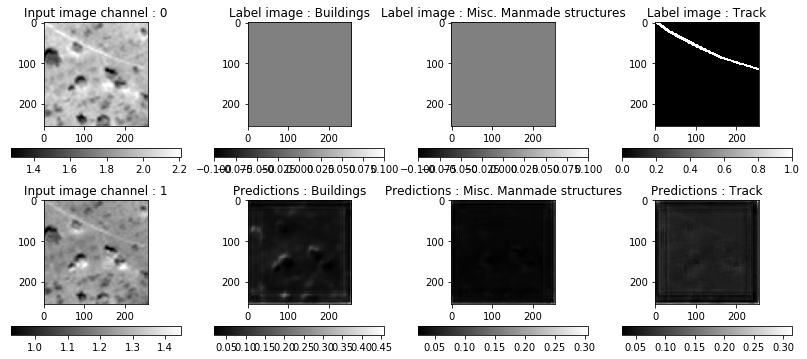

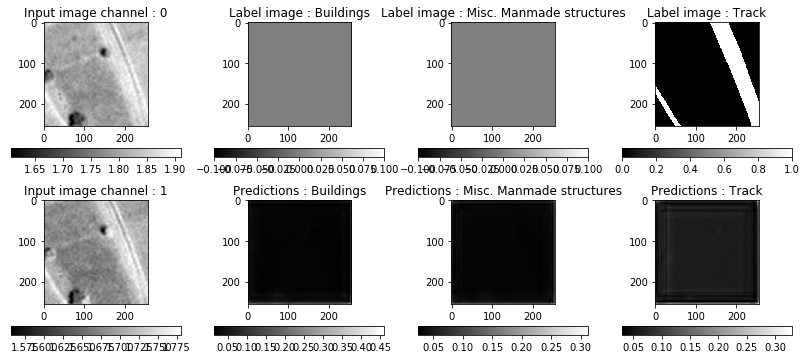

In [31]:
batch_size = 5

for X, Y in generate_images(train_files, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


(5, 4, 256, 256) 3.76119e-08 0.0021728


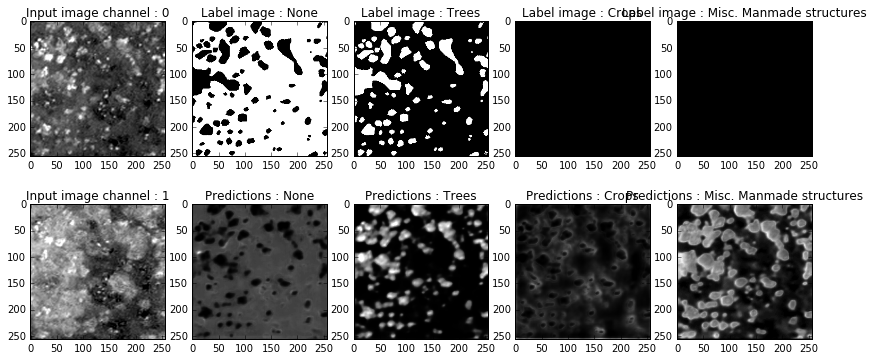

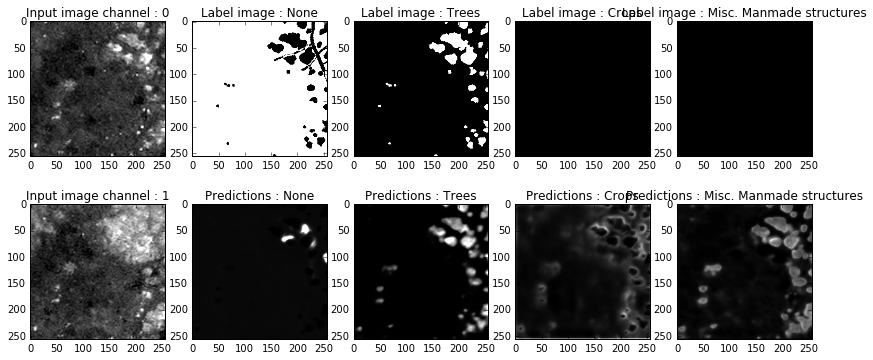

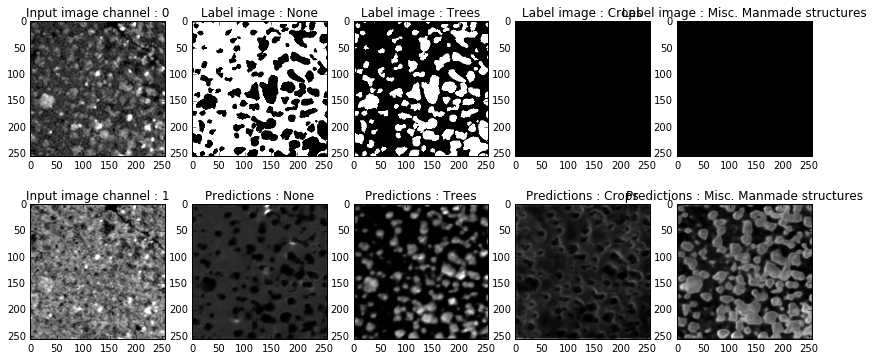

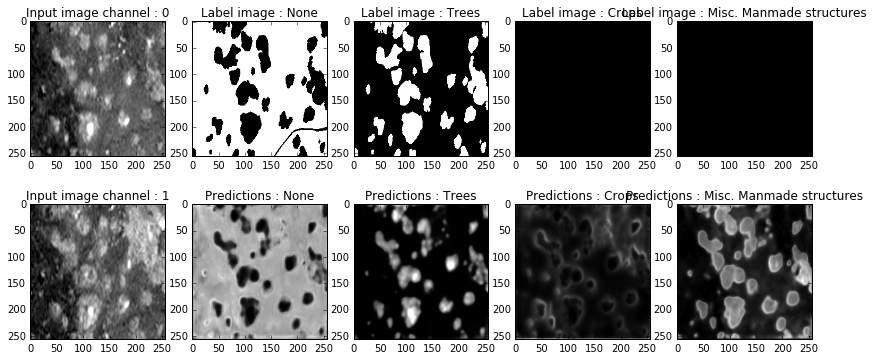

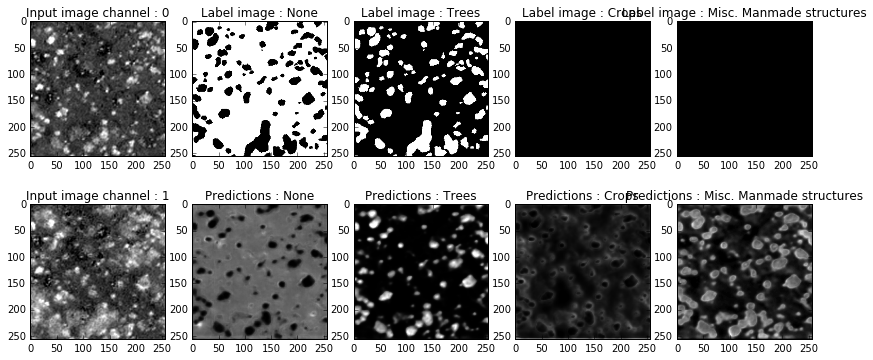

In [54]:
batch_size = 5

for X, Y in generate_images(train_tiles, batch_size):
    Y_pred = model.predict_on_batch(X)
    print Y_pred.shape, Y_pred.min(), Y_pred.max()

#     for i in range(batch_size):
#         _plot(X, Y, Y_pred, i)
#     print jaccard_coef(Y, Y_pred), jaccard_coef_int(Y, Y_pred)

    for i in range(batch_size):
        plt.figure(figsize=(14, 6))    
        plt.subplot(2,n_labels+1,1)
        display_img_1b(X[i,0,:,:])
        plt.title("Input image channel : %i" % 0)
        for j in range(n_labels):
            plt.subplot(2,n_labels+1,j+2)
            display_img_1b(Y[i,j,:,:])
            plt.title("Label image : %s" % LABELS[labels[j]])
        
        plt.subplot(2,n_labels+1,j+3)
        display_img_1b(X[i,1,:,:])   
        plt.title("Input image channel : %i" % 1)
        for jj in range(n_labels):
            plt.subplot(2,n_labels+1,jj+j+4)
            display_img_1b(Y_pred[i,jj,:,:])
            plt.title("Predictions : %s" % LABELS[labels[jj]])

    break


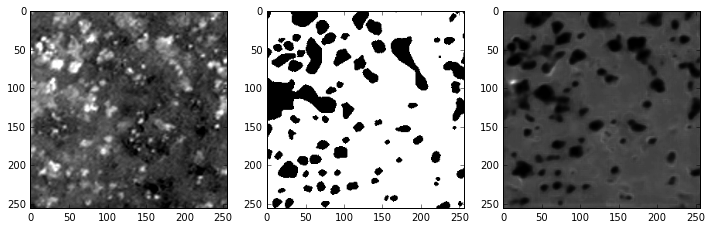

In [55]:
_plot(X, Y, Y_pred, 0, 0)

In [46]:
y = Y_pred[0,2,:,:]
print y.min(), y.max()

2.69546e-07 0.000206497
